<a href="https://colab.research.google.com/github/eduardofv/lang_model_eval/blob/master/base-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Model Evaluation

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
EXPERIMENT_CONFIG = {
    "EXPERIMENT-NAME": "base", 
    "EXPERIMENT-VERSION": "v1",
}

## Version log

### base

Punto de partida


## Development

### Initialize

In [0]:
%matplotlib inline

import sys
import os

import time
import pickle
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as k
import tensorflow_hub as hub

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import balanced_accuracy_score

In [0]:
DATA_DIR = "../data"
LOG_DIR = "../logs"
SAVED_MODEL_DIR = "../saved_models"

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  DATA_DIR = "/content/drive/My Drive/datasets/lang_model_eval"
  LOG_DIR = "logs"
  SAVED_MODEL_DIR = "saved_models"
  !mkdir logs
  !mkdir saved_models

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘logs’: File exists
mkdir: cannot create directory ‘saved_models’: File exists


### Experiment Config

In [0]:
EC = EXPERIMENT_CONFIG

EC["RANDOM_SEED"] = 12348
EC["DATASET_FN"] = f"{DATA_DIR}/es-train.csv"
EC["ROWS_TO_LOAD"] = None#None == all 
# how much data will reserve for test set (of the DS prop to use) (0.10)
EC["TEST_SET_SPLIT"] = 0.002

#TFHUB_EMB_MODEL = "https://tfhub.dev/google/universal-sentence-encoder/2" 
# download the module manually if network problems 
# like URLError: <urlopen error [Errno -3] Temporary failure in name resolution>
# check https://www.tensorflow.org/hub/common_issues 
#TFHUB_EMB_MODEL = "../tf_hub_cache/gnews-swivel-20dim-v1"

#TFHUB_EMB_MODEL = "https://tfhub.dev/google/nnlm-es-dim50-with-normalization/2" #
#TFHUB_EMB_MODEL_DIM = 50
EC["TFHUB-EMB_MODEL"] = "https://tfhub.dev/google/tf2-preview/nnlm-es-dim128-with-normalization/1"
EC["TFHUB-EMB_MODEL_DIM"] = 128

#Model parameters
EC["MODEL-LM_IS_TRAINABLE"] = True
EC["MODEL-DENSE_UNITS"] = 512
EC["MODEL-DENSE_ACTIVATION"] = "relu"
EC["MODEL-DENSE_DROPOUT_RATE"] = 0.25
EC["MODEL-OPTIMIZER"] = "Adam"
EC["MODEL-LOSS"] = 'sparse_categorical_crossentropy'

#Train parameters
EC["TRAIN-BATCH_SIZE"] = 1024
EC["TRAIN-EPOCHS"] = 8
EC["TRAIN-INITIAL_EPOCH"] = 0
# how much of the data will be used for validation (of the DS prop to use) (0.05)
EC["TRAIN-VALIDATION_SET_SPLIT"] = 0.0005

EC["RESULTS-HISTORIES"] = []

# specify a small proportion to speed things while testing, 1.0 when running full training
#DATASET_PROPORTION_TO_USE = 1.0

In [0]:
#initialize env
#seeds to make reproducible
#todo: check reproducibility
np.random.seed(EC["RANDOM_SEED"])
tf.random.set_seed(EC["RANDOM_SEED"])

pd.options.display.max_rows = 10

In [0]:
def show_env(as_string=True):
    my_env = []
    my_env.append(f"Host: {os.getenv('HOST_HOSTNAME')}_{os.getenv('HOSTNAME')}")
    a = !uname -a
    my_env.append(f"OS: {a[0]}")
    my_env.append(f"Python: {sys.version}")
    my_env.append(f"Tensorflow: {tf.__version__}")
    if len(tf.config.list_physical_devices("GPU")):
        my_env.append("GPU: available")
        a=!nvidia-smi -L
        my_env.append("\n".join(a))
    else:
        my_env.append("GPU: not available")
    my_env.append(f"Keras: {tf.keras.__version__}")
    my_env.append(f"TFHub: {hub.__version__}")
    if as_string:
        my_env = "\n".join(my_env)
    return my_env

## Load and prepare datasets

In [0]:
df = pd.read_csv(EC['DATASET_FN'], 
                 nrows = EC['ROWS_TO_LOAD']).dropna(axis=0).sample(frac=1).reset_index()
df = df[["title", "category"]]
df.head()

,title,category
0,Neumáticos Windforce 205r55r16 91v Catchgre Gp100,AUTOMOTIVE_TIRES
1,Colchoneta Con Cierre 1 X 0.5 X 0.04 M Quuz Azul,EXERCISE_MATS
2,Bomba De Freno Doble Circuito Fiat 125,BRAKE_MASTER_CYLINDERS
3,Lamparas H4 Osram.,CAR_LIGHT_BULBS
4,Sensor Rpm Posicion Ciguenal Arbol Bmw 323ti,CAR_ENGINE_CAMSHAFT_SENSORS


In [0]:
output_dim = len(df["category"].unique())
print(f"Unique categories: {output_dim}")

Unique categories: 1574


In [0]:
cat_dict = dict(zip(df["category"].unique(), np.arange(output_dim)))
inverse_cat_dict = dict(zip(cat_dict.values(), cat_dict.keys()))
labels = df["category"].map(cat_dict)

### Split datasets

In [0]:
num_samples = len(df)
num_test_samples = int(num_samples * EC["TEST_SET_SPLIT"])
num_training_samples = num_samples - num_test_samples

training_set_data = df["title"].head(num_training_samples)
training_set_labels = labels[:num_training_samples]
test_set_data = df["title"].tail(num_test_samples)
test_set_labels = labels[-num_test_samples:]

print(f"Training set shape: {training_set_data.shape}")
print(f"Training labels shape: {training_set_labels.shape}")
print(f"Test set shape: {test_set_data.shape}")
print(f"Test labels shape: {test_set_labels.shape}")

Training set shape: (9980000,)
Training labels shape: (9980000,)
Test set shape: (20000,)
Test labels shape: (20000,)


### Build Model

In [0]:
## load TF Hub embedding module
hub_layer = hub.KerasLayer(EC["TFHUB-EMB_MODEL"], 
                           output_shape=[EC["TFHUB-EMB_MODEL_DIM"]], 
                           input_shape=[], 
                           trainable=EC["MODEL-LM_IS_TRAINABLE"], 
                           dtype=tf.string,
                           name="LANG_MODEL") 
#hub_layer(np.array(training_set_data[:3]))

In [0]:
model = Sequential(name = f"{EC['EXPERIMENT-NAME']}-{EC['EXPERIMENT-VERSION']}")
model.add(hub_layer)
model.add(Dense(units = EC["MODEL-DENSE_UNITS"], 
                activation = EC["MODEL-DENSE_ACTIVATION"],  
                name = "DEN_1"))
model.add(Dropout(rate = EC["MODEL-DENSE_DROPOUT_RATE"],
                 name = "DROP_1"))
model.add(Dense(units = EC["MODEL-DENSE_UNITS"], 
                activation = EC["MODEL-DENSE_ACTIVATION"],  
                name = "DEN_2"))
model.add(Dropout(rate = EC["MODEL-DENSE_DROPOUT_RATE"],
                 name="DROP_2"))

model.add(Dense(output_dim, activation="softmax", name="DEN_OUT"))

model.compile(optimizer=EC["MODEL-OPTIMIZER"], 
              loss=EC["MODEL-LOSS"])
EC["MODEL-SUMMARY"] = []
model.summary(print_fn = lambda x: EC["MODEL-SUMMARY"].append(x))
model.summary()

Model: "base-v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LANG_MODEL (KerasLayer)      (None, 128)               125009920 
_________________________________________________________________
DEN_1 (Dense)                (None, 512)               66048     
_________________________________________________________________
DROP_1 (Dropout)             (None, 512)               0         
_________________________________________________________________
DEN_2 (Dense)                (None, 512)               262656    
_________________________________________________________________
DROP_2 (Dropout)             (None, 512)               0         
_________________________________________________________________
DEN_OUT (Dense)              (None, 1574)              807462    
Total params: 126,146,086
Trainable params: 126,146,086
Non-trainable params: 0
_____________________________________________

### Train and Test

In [0]:
#run params
runid = "%s-%s-%s"%\
    (EC["EXPERIMENT-NAME"],
     EC["EXPERIMENT-VERSION"],
     time.strftime(time.strftime('%y%m%d_%H%M',time.localtime())))

EC["EXPERIMENT-RUNID"] = runid

#Create saved model dir     
directory = SAVED_MODEL_DIR+"/"+runid
if not os.path.exists(directory):
    os.makedirs(directory)
EC["EXPERIMENT-SAVE_DIR"] = directory

EC["EXPERIMENT-LOG_DIR"] = f"{LOG_DIR}/{runid}"
EC["EXPERIMENT-BEST_MODEL_FN"] = f"{directory}/model.hdf5"

EC["EXPERIMENT-ENVIRONMENT"]  = show_env(as_string=False)

print(show_env())
print(f"runid: {runid}")

Host: None_877b86455e1c
OS: Linux 877b86455e1c 4.14.137+ #1 SMP Thu Aug 8 02:47:02 PDT 2019 x86_64 x86_64 x86_64 GNU/Linux
Python: 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
Tensorflow: 2.1.0-rc1
GPU: available
GPU 0: Tesla T4 (UUID: GPU-60d41257-a815-c494-596b-8b066b3b033d)
Keras: 2.2.4-tf
TFHub: 0.7.0
runid: base-v1-200118_0132


In [0]:
print('Training...')

tensorboard = TensorBoard(log_dir=EC["EXPERIMENT-LOG_DIR"])
checkpoint = ModelCheckpoint(EC["EXPERIMENT-BEST_MODEL_FN"], 
                             monitor='val_loss',
                             verbose=1, save_best_only=True, mode="min")

# train
t0 = time.time()
EC["EXPERIMENT-STARTED_AT"] = t0
print("Start:" + time.strftime("%Y%m%d_%H%M", time.localtime()))
history = model.fit(np.array(training_set_data), 
          training_set_labels,
          batch_size = EC["TRAIN-BATCH_SIZE"],
          epochs = EC["TRAIN-EPOCHS"],
          initial_epoch = EC["TRAIN-INITIAL_EPOCH"],
          validation_split = EC["TRAIN-VALIDATION_SET_SPLIT"],
          verbose=1,
          callbacks=[tensorboard, checkpoint])

tfin = time.time()
EC["EXPERIMENT-FINISHED_AT"] = tfin
print("End:" + time.strftime("%Y%m%d_%H%M",time.localtime()))
ttook = tfin - t0 
EC["EXPERIMENT-TRAINIG_TOOK"] = ttook
print(f"{ttook} sec, {ttook/60} min, {ttook/3600} hrs")

Training...
Start:20200118_0132
Train on 9975010 samples, validate on 4990 samples
Epoch 1/8
9974784/9975010 [============================>.] - ETA: 0s - loss: 1.0230
Epoch 00001: val_loss improved from inf to 0.71248, saving model to saved_models/base-v1-200118_0132/model.hdf5
9975010/9975010 [==============================] - 803s 81us/sample - loss: 1.0230 - val_loss: 0.7125
Epoch 2/8
9974784/9975010 [============================>.] - ETA: 0s - loss: 0.7151
Epoch 00002: val_loss improved from 0.71248 to 0.66751, saving model to saved_models/base-v1-200118_0132/model.hdf5
9975010/9975010 [==============================] - 802s 80us/sample - loss: 0.7151 - val_loss: 0.6675
Epoch 3/8
9974784/9975010 [============================>.] - ETA: 0s - loss: 0.6553
Epoch 00003: val_loss improved from 0.66751 to 0.65212, saving model to saved_models/base-v1-200118_0132/model.hdf5
9975010/9975010 [==============================] - 810s 81us/sample - loss: 0.6553 - val_loss: 0.6521
Epoch 4/8
99747

In [0]:
EC["RESULTS-HISTORIES"].append(history.history)

## Test

In [0]:
#Use last model
analysis_model = model
#Load best model
#analysis_model = tf.keras.models.load_model(directory+"/model.hdf5", 
#                                            custom_objects={
#                                                "KerasLayer":hub_layer
#                                            })
print("Predict:")
predictions = analysis_model.predict(np.array(test_set_data), verbose=1)

Predict:
20000/20000 [==============================] - 4s 207us/sample


In [0]:
#predictions[0]

In [0]:
inverse_cat_dict = dict(zip(cat_dict.values(), cat_dict.keys()))
predicted_categories = [inverse_cat_dict[np.argmax(p)] for p in predictions]
#predicted_categories

In [0]:
real_categories = [inverse_cat_dict[p] for p in test_set_labels]
#real_categories

### Balanced Accuracy

In [0]:
bac = balanced_accuracy_score(real_categories, predicted_categories)
EC["RESULTS-BALANCED_ACCURACY"] = bac
bac

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


0.8326882554972607

### Save results with metadata

In [0]:
EC

{'DATASET_FN': '/content/drive/My Drive/datasets/lang_model_eval/es-train.csv',
 'EXPERIMENT-BEST_MODEL_FN': 'saved_models/base-v1-200118_0132/model.hdf5',
 'EXPERIMENT-ENVIRONMENT': ['Host: None_877b86455e1c',
  'OS: Linux 877b86455e1c 4.14.137+ #1 SMP Thu Aug 8 02:47:02 PDT 2019 x86_64 x86_64 x86_64 GNU/Linux',
  'Python: 3.6.9 (default, Nov  7 2019, 10:44:02) \n[GCC 8.3.0]',
  'Tensorflow: 2.1.0-rc1',
  'GPU: available',
  'GPU 0: Tesla T4 (UUID: GPU-60d41257-a815-c494-596b-8b066b3b033d)',
  'Keras: 2.2.4-tf',
  'TFHub: 0.7.0'],
 'EXPERIMENT-FINISHED_AT': 1579317617.3920755,
 'EXPERIMENT-LOG_DIR': 'logs/base-v1-200118_0132',
 'EXPERIMENT-NAME': 'base',
 'EXPERIMENT-RUNID': 'base-v1-200118_0132',
 'EXPERIMENT-SAVE_DIR': 'saved_models/base-v1-200118_0132',
 'EXPERIMENT-STARTED_AT': 1579311178.332321,
 'EXPERIMENT-TRAINIG_TOOK': 6439.059754610062,
 'EXPERIMENT-VERSION': 'v1',
 'MODEL-DENSE_ACTIVATION': 'relu',
 'MODEL-DENSE_DROPOUT_RATE': 0.25,
 'MODEL-DENSE_UNITS': 512,
 'MODEL-LM_IS_

In [0]:
meta_fn = f"{EC['EXPERIMENT-SAVE_DIR']}/experiment-metadata.json"
EC["EXPERIMENT-METADATA_FN"] = meta_fn
with open(meta_fn, "wt") as fo:
    fo.write(json.dumps(EC))

### History graphs

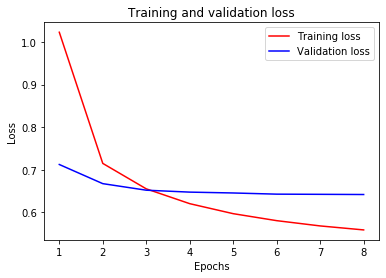

In [0]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Results Analysis

In [0]:
test = pd.DataFrame({
    'title':np.array(test_set_data),
    'real':real_categories,
    'predicted':predicted_categories
})
#test

In [0]:
pd.options.display.max_rows = 50
test.head(50)

,title,real,predicted
0,Alfa Romeo 166 Exelente Carr Y Papeles A Repar...,CRASHED_CARS,CLASSIC_CARS
1,Bombacha Universal Jackard Margarita Sol Y Oro...,PANTIES,PANTIES
2,"Teclados Netbook Del Gobierno (bangho, Samsung...",LAPTOP_KEYBOARDS,NETBOOKS
3,Cinta Erc 27 Alternativa,PRINTER_RIBBONS,PRINTER_RIBBONS
4,Tapa De Válvulas Clio 1.8 1.7 Francés 19 Chama...,AUTOMOTIVE_ENGINE_VALVE_COVERS,AUTOMOTIVE_ENGINE_VALVE_COVERS
5,Lote Revista Humor Chancho Satiricon Negro Pol...,MAGAZINES,MAGAZINES
6,Porcelanato Granito White 33x66 - Cerro Negro,PORCELAIN_TILES,PORCELAIN_TILES
7,Griferia Cocina Lavadero Monocomando Pared Hau...,KITCHEN_FAUCETS,KITCHEN_FAUCETS
8,Pedal De Delay Digital Boss Dd-500 Dd500 Nuevo...,PEDAL_EFFECTS,PEDAL_EFFECTS
9,Tecla Levantavidrios Chevrolet S10 Blazer 199...,CAR_WINDOW_SWITCHES,CAR_WINDOW_SWITCHES


In [0]:
test.to_csv(directory+"/test-results.csv", index=False)

In [0]:
with open(directory+"/inverse_cat_dict.pickle", "wb") as fo:
    pickle.dump(inverse_cat_dict, fo)

In [0]:
with open(directory+"/predictions.pickle", "wb") as fo:
    pickle.dump(predictions, fo)